# Import the Libraires

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam


# Load Your CSV File

In [2]:
df = pd.read_csv("sample.csv")
df.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


# Preprocessing (Encode + Scale)

In [3]:
# Encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns.tolist()

# Convert label column to 0/1 if it exists
if 'label' in df.columns:
    df['label'] = df['label'].apply(lambda x: 0 if x == 'normal.' or x == 0 else 1)
else:
    df['label'] = -1  # For unsupervised use

# Label encoding
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']
X_scaled = MinMaxScaler().fit_transform(X)


# Isolation Forest

In [4]:
iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
preds_if = iso_model.fit_predict(X_scaled)
preds_if = [0 if p == 1 else 1 for p in preds_if]

print(f"✅ Isolation Forest detected {sum(preds_if)} anomalies out of {len(preds_if)} rows.")


✅ Isolation Forest detected 64660 anomalies out of 494020 rows.


# Autoencoder

In [5]:
input_dim = X_scaled.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(20, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')

# Train
autoencoder.fit(X_scaled, X_scaled, epochs=5, batch_size=256, verbose=0)

# Predict
reconstructions = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# Threshold
threshold = np.percentile(mse, 95)
preds_ae = [1 if e > threshold else 0 for e in mse]

print(f"✅ Autoencoder detected {sum(preds_ae)} anomalies out of {len(preds_ae)} rows.")


15439/15439 ━━━━━━━━━━━━━━━━━━━━ 12s 743us/step
✅ Autoencoder detected 24701 anomalies out of 494020 rows.


# Evaluation

In [6]:
def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    print(f"\n📊 {name} Evaluation:")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")

# Run evaluations
evaluate_model("Isolation Forest", y, preds_if)
evaluate_model("Autoencoder", y, preds_ae)



📊 Isolation Forest Evaluation:
Accuracy:  0.8691
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

📊 Autoencoder Evaluation:
Accuracy:  0.9500
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000


# MSE Plot (Autoencoder)

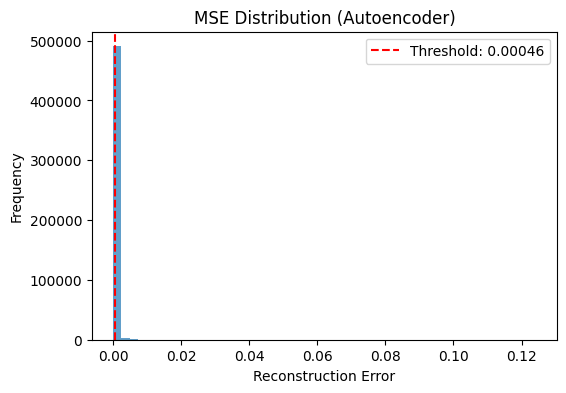

In [7]:
plt.figure(figsize=(6, 4))
plt.hist(mse, bins=50, alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.5f}')
plt.title('MSE Distribution (Autoencoder)')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()
